In [1]:
import numpy as np
import matplotlib.pyplot as plt

# auto differentiation library
import torch
from torch.autograd import grad, Function
import torch.nn.functional as F  # usual functions
import torch.nn as nn  # for defining Neural Networks
import torch.optim as optim

# notebook specific library for displays
from tqdm.notebook import tqdm
from IPython.display import display, Markdown

# Pytorch's Tensors

Pytorch contains a class `Tensor` which is a wrapper for array, matrices, tensors... But numpy is already able to handle usual linear algebra operation and coordinate-wise operations. Pytorch brings to the table __auto-differentiation__ and __GPU operations__.
That means a Tensor contains everything necessary to backpropagate gradients through the operation which created it.

In [2]:
# defining a Tensor from a numpy array
x = np.array([3, 1, 4, 1, 5, 9, 2])
x = torch.Tensor(x)
print("Tensor type `x.type()` gives more insight on the data structure of tensor coordinates: {}".format(x.type()))
print("The tensor's shape, alternatively `x.size()` or `x.shape`: {}".format(x.shape))
print(x)
print("You can get a numpy array back with `x.numpy()`: {}".format(x.numpy()))

Tensor type `x.type()` gives more insight on the data structure of tensor coordinates: torch.FloatTensor
The tensor's shape, alternatively `x.size()` or `x.shape`: torch.Size([7])
tensor([3., 1., 4., 1., 5., 9., 2.])
You can get a numpy array back with `x.numpy()`: [3. 1. 4. 1. 5. 9. 2.]


In [3]:
# linear algebra operation
A = np.random.randn(3, x.shape[0])
A = torch.Tensor(A)

print("`torch.mv` for matrix-vector multiplication: {}".format(torch.mv(A, x)))
print("Multiplication `*` is reserved for coordinate wise multiplication.")
print("In Python, matrix multiplication is done using `@`: {}".format(A @ x))

`torch.mv` for matrix-vector multiplication: tensor([-24.0020, -15.1235,  11.3818])
Multiplication `*` is reserved for coordinate wise multiplication.
In Python, matrix multiplication is done using `@`: tensor([-24.0020, -15.1235,  11.3818])


# Pytorch's Gradient Computation

Let's say $y = f(x) \in \mathbb R$ where $f$ is a known function and $x$ is a tensor. We know how to compute the gradient of $f$ at point $x$: for Pytorch, "knowing" a function means knowing both how to compute its value at a point $x \mapsto f(x)$, but also knowing how to compute its gradient $x \mapsto \nabla f(x)$.

When computing $y$, Pytorch records that it was obtained from calling the function $f$ at point $x$. Here is an example of this computation using only one variable $y = \| x \|_2$:

In [4]:
x = torch.randn(4, requires_grad=True)
y = torch.norm(x, p='fro')
display(Markdown(r"Pytorch knows how y was defined, it records how to compute compute gradients of y: $\nabla \|\,.\|_2$ is stored as '{}'".format(y.grad_fn)))

Pytorch knows how y was defined, it records how to compute compute gradients of y: $\nabla \|\,.\|_2$ is stored as '<NormBackward0 object at 0x7fe15476a850>'

### Computing a gradient with Pytorch

In this context, $y$ represents an error (or "loss" as it is often called in machine learning) that we want to minimize with a gradient descent. 

If the user wants to compute the gradient of $y$ with respect to $x$:
- The gradient we want to compute is the gradient of $y$ with respect to other variables: we know that $y = f(x)$ so we want to compute $\nabla f(x)$.
- $f$ is a "known" function, so pytorch has access to $\nabla f$, and it has recorded the value of $x$ as well: it simply needs to compute $\nabla f(x)$.

This computation is done when calling `torch.grad` which was imported as `grad`. It needs two arguments:
- The loss whose gradient we want to compute $y$
- The list of variables with respect to which we want to compute the gradient: if $\mathcal y = f(x, z)$, and we want the gradient with respect to both $x = (x_1, \dots, x_n)$ and $z = (z_1, \dots, z_m)$, then the output will be
$$
    \nabla f(x, z) = \left(
        \frac{\partial \mathcal L}{\partial x_1}, \dots, \frac{\partial \mathcal L}{\partial x_n},
        \frac{\partial \mathcal L}{\partial z_1}, \dots, \frac{\partial \mathcal L}{\partial z_m}
    \right) = \left( \nabla_x f(x, z) \ | \ \nabla_z f(x, z) \right)
$$

Here is what it looks like with the previous example $y = \| x \|_2$:

In [5]:
grad_y = grad(y, [x])
print("grad returns a list of gradients refering to the list of arguments [x]: {}".format(grad_y))
grad_y_x = grad_y[0]  # index 0 because x is at index 0 in the list [x]
display(grad_y_x)

grad returns a list of gradients refering to the list of arguments [x]: (tensor([-0.0076,  0.0948,  0.1210,  0.9881]),)


tensor([-0.0076,  0.0948,  0.1210,  0.9881])

#### Exercise 1 - Sanity check: compute the gradient $\nabla_x y$ by hand and compare your result to `grad_y_x`

In [6]:
run -i solutions/exo1

Error between grad_y_x and analytical gradient: 0.00E+00


### Other differential operators:

Know that the `torch.autograd` package contains automatic computations for other differential operators. For example, the function `jacobian` extends `grad` to non-scalar inputs and the function `hessian` computes second order derivatives.

# First mention of a neural network

Let's present an abstract description of neural networks through a basic example: recognizing photos of cats and dogs. 
- $x \in \mathbb R^d$ contains a data sample: in this example $x$ would be the image, but in other contexts it could be sounds, medical records, GPS informations, internet history, DNA information, etc... or even a combination of multiple of those.
- For a binary classification task, $y \in \{0, 1\}$ represents the prediction that we make for that sample e.g. if the image in $x$ is more likely to be a cat $0$ or a dog $1$ ?

Often, we will assume that there exists an _oracle_ function $f:\, \mathbb R^d \mapsto \{0, 1\}$ such that $f(x)$ is always the correct answer, or at least the best$^*$ answer that can be given.

*: here, the "best" is defined in relation to an error that must be defined as part of the mathematical formulation of the problem we are confronted to.

### An abstract neural network

In general, neural networks are a class of parametrized functions $f_\theta$ mapping an input to a prediction: $y = f_\theta(x)$. Here, $\theta \in \mathbb R^p$ is the set of parameters used by the network.

The goal is to make good prediction, _i.e._ to estimate the class of any probable data sample $x$: $\tilde y = f_\theta(x)$ approximates $y = f(x)$.

# Gradient Descent in Pytorch

Let $A \in \mathcal M_{q, p}(\mathbb R)$ and $y \in \mathbb R^q$. We want to find the pseudo inverse $x = A^{<-1>}y \in \mathbb R^p$ of $y$. This is typically done by defining
$$
    \tilde x = argmin_{x \in \mathbb R^p} \| Ax - y \|_2^2
$$

In [7]:
q, p = 3, 4
A = torch.randn(q, p)
y = torch.randn(q)

lr = 1e-2
niter = 500

#### Exercise 2: Using a random initialization and Pytorch's `grad` function, implement by hand a gradient descent to minimize $\| Ax - y \|_2^2$ with learning rate (step size) `lr` and `niter` steps. Plot the evolution of $\| Ax - y \|_2^2$ during the descent.

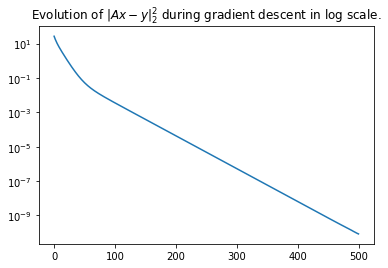

In [8]:
run -i solutions/exo2

To compute a gradient, you can also call `loss.backward` on a scalar `loss`: the gradient $\nabla_x loss$ will be computed for all $x$ on which `loss` depends, and stored in `x.grad`.

Pytorch provides `Optimizer`s to seamlessly perform gradient descents, one example is SGD (stochastic gradient descent): https://pytorch.org/docs/stable/optim.html?highlight=sgd#torch.optim.SGD.
An optimizer encapsulates the whole gradient step scheme: it knows which variables must be updated, and how to update them given the corresponding gradient.
- The convention is that the list of variables to update is given along with all descent parameters (e.g. step size) when defining the optimizer.
- As for the gradients, the optimizer will conveniently look for the gradient corresponding to `x` in `x.grad`, making it perfect to use alongside the `backward` method.
- However, since the gradient is stored in `x.grad`, we will have to reset it between each iteration. This is also automated by the optimizer using `optimizer.zero_grad()` (sets gradient with respect to all optimized variables to zero).

In [9]:
x = torch.randn(p, requires_grad=True)
optimizer = torch.optim.SGD([x], lr=lr)

#### Exercise 3: Same as Exercise 2 using the optimizer defined above.

NameError: name 'lr_scd' is not defined

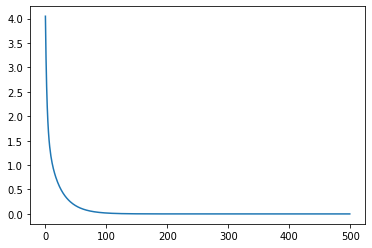

In [10]:
run -i solutions/exo3

### Machine Learning technical jargon
In supervized learning, we fix the parameters $\theta$ with what refer to as training, using a dataset.
- A __dataset__ is a set of pairings between data samples $x^{(1)} \in \mathbb R^d,\, \dots,\, x^{n} \in \mathbb R^d$, and the corresponding correct answer:
    - for example, humans are very good at recognizing cats from dogs on images so the network can be trained to match human performance
    - in other contexts, the correct answer can be an objective truth: did the meteorological $x^{(i)}$ result in rain one hour later ? did the patient carrying DNA $x^{(i)}$ develop a specific cancer before the age of 50 ? Did the internet user with the internet history $x^{(i)}$ buy the product advertised ?
    - we call this _correct answer_ the sample's __label__.
- We can rewrite $f_\theta(x) = f(x, \theta)$. $f$ is a function defined by the user, so its gradient is known: we don't care much about $\nabla_x f$, but $nabla_\theta f$ allows us to optimise $\theta$ through a gradient decent. __Training__ is just technical jargon for this gradient descent.

Note: to have well defined gradients, we can't use $\tilde y = f_\theta(x) \in \{0, 1\}$ and relax it to $\tilde y \in [0, 1]$ or even $\tilde y \in \mathbb R$.

#### Dataset
We define a fully random dataset: points $x \sim \mathcal N(0, 1)$ and associated labels $y \sim Bernoulli(1/2)$. Of course this is very simplistic, but it will allow us to define our first models and to point out some classic neural network caveats.

Pytorch provides abstract representation of dataset with the `Dataset`, from which multiple classes inherit depending on the nature of the dataset. Here we will use `torch.utils.data.TensorDataset`since both `x` and `y` are already tensors.

A `DataLoader` class is also provided to be able to seamlessly iterate over all samples in the dataset in small batches (subset small enough to be able to fit in memory but big enough for the stochastic gradient descent to be efficient).

In [11]:
n = 1000  # number of training samples
p = 20  # dimension of each sample
x = torch.randn(n, p)  # each of the n samples is in R^p
y = torch.randint(0, 1, (n,), dtype=x.dtype)  # each of the n labels is in {0, 1}
print("x:", x.shape)
print("y:", y.shape)

dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

print("\nWe can now iterate over dataloader to get a subset of x with the corresponding subset of y:")
for x_batch, y_batch in dataloader:
    print("    batch of samples:", x_batch.shape, "    corresponding labels:", y_batch.shape)
print("Notice that the last batch is incomplete as 1000 is not a multiple of 32.\n"
      "Pytorch takes care of it so we don't have to worry about it.")

x: torch.Size([1000, 20])
y: torch.Size([1000])

We can now iterate over dataloader to get a subset of x with the corresponding subset of y:
    batch of samples: torch.Size([32, 20])     corresponding labels: torch.Size([32])
    batch of samples: torch.Size([32, 20])     corresponding labels: torch.Size([32])
    batch of samples: torch.Size([32, 20])     corresponding labels: torch.Size([32])
    batch of samples: torch.Size([32, 20])     corresponding labels: torch.Size([32])
    batch of samples: torch.Size([32, 20])     corresponding labels: torch.Size([32])
    batch of samples: torch.Size([32, 20])     corresponding labels: torch.Size([32])
    batch of samples: torch.Size([32, 20])     corresponding labels: torch.Size([32])
    batch of samples: torch.Size([32, 20])     corresponding labels: torch.Size([32])
    batch of samples: torch.Size([32, 20])     corresponding labels: torch.Size([32])
    batch of samples: torch.Size([32, 20])     corresponding labels: torch.Size([32])

#### Model
We start with a logistic regression:
$$
    \tilde y = f_\theta(x) = \sigma(Ax + b)
$$
where $f_\theta$ is the model, $\theta = (A, b)$ represent all its parameters and $\sigma: z\in\mathbb R \mapsto \frac{1}{1 + \exp(z)}$ is the sigmoid function.
Here, $\tilde y \in [0, 1]$ is supposed to approximate the probability $p(y=1|x)$.

In pytorch, we define model (or more generally parameterized functions) as new classes which inherit from nn.Module. When doing so, it is implied that all functions used in the model are _known_ (able to compute the function's image and gradient) by Pytorch.

In [37]:
class LogisticRegression(nn.Module):
    """A Logistic Regression Module implemented in Pytorch.
    
    Input:
        p: int
            Dimension of the input space
    
    Argument:
        x: torch.Tensor
            Input tensor of shape [B, p] where B is an arbitrary batch size.

    Output:
        y_tilde: torch.Tensor
            Approximation of p(y=1|x) under a logistic regression model, with shape [B,].
    """
    
    def __init__(self, p):
        """Initialize a LogisticRegression model.
        
        notes:
            - This method is called when calling 'model = LogisticRegression(p)'.
            - The first argument self is not defined by the user, it is a way for the object to manipulate itself.
        """
        super().__init__()  # call the __init__ method of nn.Module from which LogisticRegression inherits.
        self.linear = nn.Linear(p, 1, bias=True)  # linear layer, contains the weights A and the bias b.
        
    def forward(self, x):
        """Return y_tilde = sigma(Ax + b).
        
        Because of nn.Module, this method is what will be called when writing model(x).
        """
        y_tilde = torch.sigmoid(self.linear(x))
        # remove dimension 1 which is now useless
        y_tilde = y_tilde.squeeze(1)
        return y_tilde

model = LogisticRegression(p)

#### Optimizing the model's parameters with gradient descent

We made our model inherit from `nn.Module`, which make a lot of tedious work automatic. For example, when defining the optimizer, we will need to know all the model's parameters: the list is given by `model.parameters()`.

What is going on: `nn.Module` is a class defined by Pytorch developers. It implements the method `parameters()` which our model inherits from `nn.Module`. This method simply iterates over all parameterized function defined in the object's `__init__` method: here there is only an instance of `nn.Linear`. These functions are implemented by Pytorch in such a way that it knows how to list its own parameters, making all of this possible.

Advanced note: When defining model parameters by hand, you may need to explicitely tell Pytorch that you did so with the method `register_parameter`. For now, don't worry about it since we will only be using functions provided by pytorch like `nn.Linear`, `nn.Conv1d`, etc...

In [38]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

#### Training objective
In order to set our model parameters, we need an objective to minimize. Ideally, we would like to minimize the __accuracy__ which is the number of prediction errors:
$$
    \mathcal L^{pred}(\tilde y, y) = \left\{
                \begin{array}{ll}
                  0 \text{ if } \tilde y \geq 0.5 \text{ and } y=1\\
                  0 \text{ if } \tilde y < 0.5 \text{ and } y=0\\
                  1 \text{ otherwise,}
                \end{array}
              \right.
$$
but it is not differentiable, so its optimization is untracktable. We will be optimizing the cross entropy loss, which is a widely used loss for classification tasks, and is defined by `torch.nn.functional.binary_cross_entropy` (`torch.nn.functional` was imported as `F`): https://pytorch.org/docs/stable/nn.functional.html?highlight=binary_cross#torch.nn.functional.binary_cross_entropy

#### Exercise 4: Train the model's parameters by minimizing the binary cross entropy loss. Plot the evolution of the loss during training, and the accuracy (prediction error). Does this prediction error seem reasonable to you ?

Epoch 0: loss 7.85E-01 - accuracy 43.6%


Epoch 1: loss 3.33E-01 - accuracy 99.6%


Epoch 2: loss 1.60E-01 - accuracy 100.0%


Epoch 3: loss 1.05E-01 - accuracy 100.0%


Epoch 4: loss 7.80E-02 - accuracy 100.0%


Epoch 5: loss 6.24E-02 - accuracy 100.0%


Epoch 6: loss 5.20E-02 - accuracy 100.0%


Epoch 7: loss 4.46E-02 - accuracy 100.0%


Epoch 8: loss 3.90E-02 - accuracy 100.0%


Epoch 9: loss 3.47E-02 - accuracy 100.0%


Epoch 10: loss 3.12E-02 - accuracy 100.0%


Epoch 11: loss 2.84E-02 - accuracy 100.0%


Epoch 12: loss 2.60E-02 - accuracy 100.0%


Epoch 13: loss 2.40E-02 - accuracy 100.0%


Epoch 14: loss 2.23E-02 - accuracy 100.0%


Epoch 15: loss 2.08E-02 - accuracy 100.0%


Epoch 16: loss 1.95E-02 - accuracy 100.0%


Epoch 17: loss 1.84E-02 - accuracy 100.0%


Epoch 18: loss 1.74E-02 - accuracy 100.0%


Epoch 19: loss 1.64E-02 - accuracy 100.0%


Epoch 20: loss 1.56E-02 - accuracy 100.0%


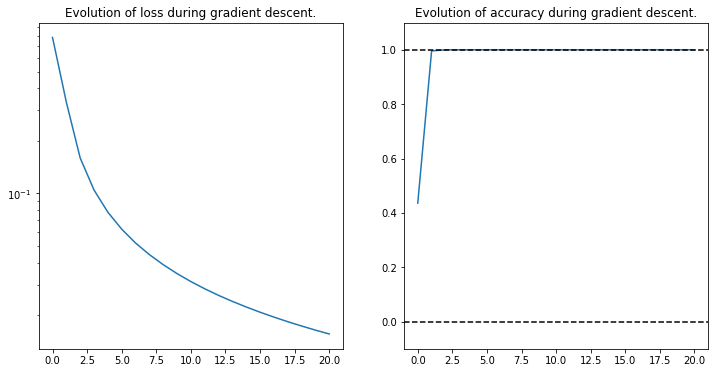

In [39]:
run -i solutions/exo4

### Computing $\nabla_\theta f$
In general, $f_\theta$ can be very complicated and include several milions of parameters: deriving its gradient by hand can be tidious if not physically impossible.

However, $f_\theta$ is often defined as a cascade of simple functions: linear functions $A_k: \mathbb R^{d_k} \mapsto \mathbb R^{d_{k+1}}$ and non-linear activations $\rho_k: \mathbb R \mapsto \mathbb R$ applied to each coordinate independantly. The parameters here are the matrices $A_k$ which are regrouped into $\theta = \left( A_1 | \dots | A_K \right)$.

This structure allows us to compute all gradients
$$
    \nabla_\theta f(x, \theta) = \left(\ \nabla_{A_1} f(x, \theta) \,| \dots \,|\, \nabla_{A_K} f(x, \theta) \ \right)
$$
using the chain-rule. The resulting algorithm is called backpropagation, we will study it next time.

# Defining functions in Pytorch

Pytorch already knows many elementary functions such as sums, sine functions, norms, etc... Other functions can be obtained through the chain rule.

#### Exercise 3: Define the function $f(x, A, b) = \max(0, Ax + b)$ where $x \in \mathbb R^{d_0}$, $A \in \mathcal M_{d_0, d_1}(\mathbb R)$ and $b \in \mathbb R^{d_1}$.

Note: $x \mapsto \max(0, x)$ is a widely used operation in deep learning, commonly refered to as ReLU for _Rectified Linear Unit_

In [ ]:
def f(x, A, b):
    """Compute the result of a fully connected layer y = max(0, Ax+b)."""

    # your code goes here
    pass

In [ ]:
d0, d1 = 4, 3

x = torch.randn(d0, requires_grad=True)
A = torch.randn(d1, d0, requires_grad=True)
b = torch.randn(d1)

#### Exercise 4: Compute $\|f(x, A, b)\|_2$ and its gradient with respect to $A$ and $b$ using the function `grad` as before. How could Pytorch know how to compute those gradients ?

In [ ]:
# your code goes here

### Defining new functions

If the function we want to use can not be defined using basic Pytorch functions (typically because one step is unstable or has unstable gradient computation), we must define it ourselves.

Pytorch's autograd package provides the class `Function` for this exact purpose:
    https://pytorch.org/docs/stable/autograd.html?highlight=function#torch.autograd.Function

Recall that in Pytorch, "knowing" a function a function means knowing how to compute it, as well as knowing how to compute its gradient.

#### Exercise 5: Define the inverse matrix function

In [ ]:
class InverseMatrix(Function):
    """A Function class for computing the inverse matrix, and its gradient."""
    
    @staticmethod
    def forward(ctx, A):
        """Compute the inverse of matrix A"""
        pass
    
    @staticmethod
    def backward(ctx, grad_output):
        """Compute the gradient of the loss with respect to A.
        
        grad_ouput contains the gradient of the loss with respect to A^-1
        """
        pass